In [ ]:
from __future__ import print_function

#The two folloing lines allow to reduce tensorflow verbosity
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='1' # '0' for DEBUG=all [default], '1' to filter INFO msgs, '2' to filter WARNING msgs, '3' to filter all msgs

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

import matplotlib.pyplot as plt
import numpy as np


print('tensorflow:', tf.__version__)
print('keras:', tf.keras.__version__)


(x_train, y_train), (x_test, y_test) = mnist.load_data()


print('x_train.shape=', x_train.shape)
print('y_test.shape=', y_test.shape)

#To input our values in our network Conv2D layer, we need to reshape the datasets, i.e.,
# pass from (60000, 28, 28) to (60000, 28, 28, 1) where 1 is the number of channels of our images
img_rows, img_cols = x_train.shape[1], x_train.shape[2]
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

#Convert to float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#Normalize inputs from [0; 255] to [0; 1]
x_train = x_train / 255
x_test = x_test / 255

print('x_train.shape=', x_train.shape)
print('x_test.shape=', x_test.shape)

num_classes = 10

#Convert class vectors to binary class matrices ("one hot encoding")
## Doc : https://keras.io/utils/#to_categorical
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
# num_classes is computed automatically here
# but it is dangerous if y_test has not all the classes
# It would be better to pass num_classes=np.max(y_train)+1



#Let start our work: creating a convolutional neural network

#####TO COMPLETE
model = keras.Sequential([
    keras.layers.Conv2D(16,3,1, activation='relu'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.1),
    keras.layers.Conv2D(16,3, 1, activation='relu'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.1),
    keras.layers.Flatten(),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='Adam',
                loss='categorical_crossentropy',
                metrics='accuracy')

hist = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_split = 0.2)

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)
print('\nTest loss:', test_loss)


##Displaying the worst 10 results. 
predictions=model.predict(x_test)
prediction_classes=np.argmax(predictions,axis=1)
real_classes = np.argmax(y_test,axis=1)

wrong_classifications = np.nonzero(prediction_classes != real_classes)[0]
max_logits = np.max(predictions[wrong_classifications], axis=1) 
worst_index = wrong_classifications[np.argsort(max_logits)[-10:]]

#plot the diagrams
worst_ten_classified_images = x_test[worst_index] 
wrong_labels = prediction_classes[worst_index]
right_labels = real_classes[worst_index]


fig = plt.figure(figsize=(30, 6))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1)
    ax.imshow(np.squeeze(worst_ten_classified_images[idx]), cmap='gray')
    ax.set_title(f'Predict={str(wrong_labels[idx])} , real={str(right_labels[idx] )}'  )
plt.show()

# Visualizing what convnets learn

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/05/29<br>
**Last modified:** 2020/05/29<br>
**Description:** Displaying the visual patterns that convnet filters respond to.

## Introduction

In this example, we look into what sort of visual patterns image classification models
learn. We'll be using the `ResNet50V2` model, trained on the ImageNet dataset.

Our process is simple: we will create input images that maximize the activation of
specific filters in a target layer (picked somewhere in the middle of the model: layer
`conv3_block4_out`). Such images represent a visualization of the
pattern that the filter responds to.


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 16)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 13, 13, 16)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 16)        2320      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 5, 5, 16)         

## Setup


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# The dimensions of our input image
img_width = 28
img_height = 28
layer_type = "conv" #either dense or conv
# Our target layer: we will visualize the filters from this layer.
# See `model.summary()` for list of layer names, if you want to change this.
layer_name = "conv2d_1"

## Build a feature extraction model


In [ ]:
# Set up a model that returns the activation values for our target layer
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)

## Set up the gradient ascent process

The "loss" we will maximize is simply the mean of the activation of a specific filter in
our target layer. To avoid border effects, we exclude border pixels.


In [ ]:

def compute_loss(input_image, filter_index, layer_type):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    if (layer_type == "conv"):
      filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    elif (layer_type == "dense"):
      filter_activation = activation[:, filter_index]
    else:
      raise NotImplementedError
    return tf.reduce_mean(filter_activation)

Our gradient ascent function simply computes the gradients of the loss above
with regard to the input image, and update the update image so as to move it
towards a state that will activate the target filter more strongly.


In [ ]:

@tf.function
def gradient_ascent_step(img, filter_index, learning_rate, layer_type):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index, layer_type)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img



## Set up the end-to-end filter visualization loop

Our process is as follow:

- Start from a random image that is close to "all gray" (i.e. visually netural)
- Repeatedly apply the gradient ascent step function defined above
- Convert the resulting input image back to a displayable form, by normalizing it,
center-cropping it, and restricting it to the [0, 255] range.


In [ ]:


def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, img_width, img_height))
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25


def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 500
    learning_rate = 0.1
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate, layer_type)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img


def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # # Center crop
    # img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img



Let's try it out with filter 0 in the target layer:


In [ ]:
from IPython.display import Image, display
from PIL import Image as Image_PIL


loss, img = visualize_filter(0)
im = Image_PIL.fromarray(img)
im = im.resize((200,200),Image_PIL.ANTIALIAS)
im.save("0.jpeg")

This is what an input that maximizes the response of filter 0 in the target layer would
look like:


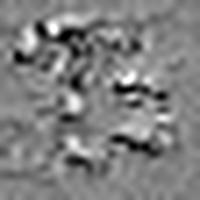

In [ ]:
from IPython.display import Image, display
display(Image("0.jpeg"))

## Visualize the first 16 filters in the target layer

Now, let's make a 8x8 grid of the first 64 filters
in the target layer to get of feel for the range
of different visual patterns that the model has learned.


In [ ]:
# Compute image inputs that maximize per-filter activations
# for the first 16 filters of our target layer
all_imgs = []
n = 3
for filter_index in range(n*n):
    print("Processing filter %d" % (filter_index,))
    loss, img = visualize_filter(filter_index)
    img = Image_PIL.fromarray(img)
    img = img.resize((200,200),Image_PIL.ANTIALIAS)
    img = np.array(img)
    all_imgs.append(img)

# Build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 1

cropped_width = 200
cropped_height = 200
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height))

# Fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img = all_imgs[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height
        ] = img

plt.imsave('stiched_filters.png', stitched_filters, cmap='viridis')
# keras.preprocessing.image.save_img("stiched_filters.jpg", stitched_filters)

from IPython.display import Image, display
import matplotlib.pyplot as plt

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8


Image classification models see the world by decomposing their inputs over a "vector
basis" of texture filters such as these.

See also
[this old blog post](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html)
for analysis and interpretation.


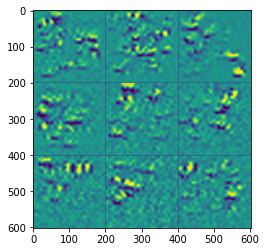

In [ ]:
plt.imshow(stitched_filters, cmap='viridis')
plt.show()

Check filters

In [ ]:
# model.summary()

In [ ]:
# layer_conv = model.get_layer(name="conv2d")
# # np.std(layer_conv.get_weights()[0][:,:,0,:], axis=2)